# 1. Cleaning data

### Data import

From the ``/data/Train2/files.csv`` we import all the time series recorded in the df list. Each entry of df, df[i] is a Pandas DataFrame with columns ``x, y, z, t``. 

The labels are replaced according to the three categories and stored in a list.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import interpolate

# Creating list of Pandas Dataframes
df_list = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Loop through each file in the Train2 directory and append the data to df_list
i = 0
for filename in os.listdir('../data/Train2'):
    df_list.append(pd.read_csv(os.path.join('../data/Train2',filename),header = None, names = ['x','y','z','time']))
    i = i + 1    

# Replace the original class labels with new labels for classification with 3 classes
labels = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,2,2,2,3,3])

# Replace the original class labels with new labels for classification with 8 classes
# data['class'] = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8])

### Missing values
We verify that there are no missing values

In [2]:
# Check for missing values in each dataframe in df_list
missing_values = False
for df in df_list:
    if df.isnull().values.any():
        missing_values = True
        break

# Print a message if there are missing values
if missing_values:
    print('There are missing values in at least one dataframe')
else:
    print('There are no missing values in any dataframe')

There are no missing values in any dataframe


### Sampling time

Before moving on, we focused on the timestep. According to official documentation, the sampling frequency of the accelerometer should be the same for all registration. Many features extracted may rely and be greatly simplified by having a homogeneus timestep

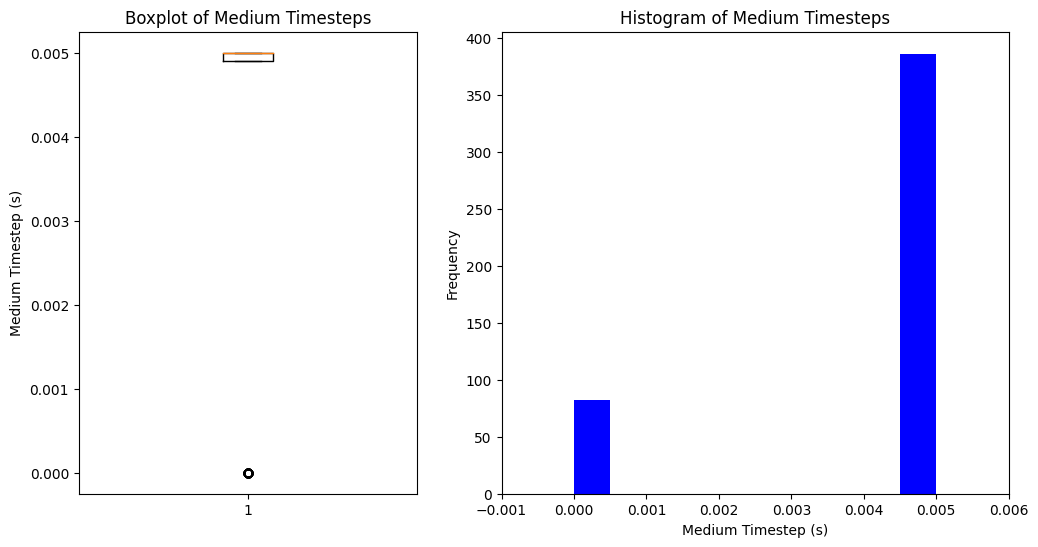

In [3]:
# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)

# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

# Create a boxplot of the medium timesteps
ax1.boxplot(medium_timesteps)
ax1.set_title('Boxplot of Medium Timesteps')
ax1.set_ylabel('Medium Timestep (s)')

# Create a histogram of the medium timesteps
ax2.hist(medium_timesteps, bins=10, color = 'blue')
ax2.set_title('Histogram of Medium Timesteps')
ax2.set_xlabel('Medium Timestep (s)')
ax2.set_ylabel('Frequency')
xticks = ax2.get_xticks()
xtick_labels = [f'{xtick:.2f}' for xtick in xticks]
ax2.set_xticks(xticks)
plt.show()

The sampling rate seems almost always coherent with what was defined on the documentation. 
There seems to be a few exceptions: in the data, time is always recorded with five digits **regardless of the number of decimal digits**.

Since starting time is not set to zeroes but varies accross observations, every observation with starting 
$\text{time} >10$ or $\text{time}>100$ will have respectively three or two digits decimal precision.

This means that some timeseries will have points recorded apparently at the same time:

In [4]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])

0    103.47
1    103.47
2    103.48
Name: time, dtype: float64


We thus process the whole dataset using pre_process_data to shift the starting time to zero and register the correct sampling rate (200Hz) to the timeseries at fault

In [5]:
def pre_process_data(data_acc, fs):
    """
    This function interpolates the accelerometer and gyroscope data to the same time interval.

    Parameters
    ----------
    data_acc : nd-array
        Accelerometer data of specified activity
    fs : int
        Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)
    """

    # Extract the time and accelerometer data from the input data
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # Define the time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # Interpolate the accelerometer data
    data_act_acc = np.array(data_act_acc)
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # Concatenate the interpolated data and the new time array
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns = ['x', 'y', 'z', 'time'])

    return data

def plot_data(data):
    """This function plots the accelerometer and gyroscope data.

    Parameters
    ----------
    data nd-array
    Interpolated data

    Returns
    -------
    None

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(data['time'], data['x'])
    axs[0, 0].set_title('X Acceleration')
    axs[0, 1].plot(data['time'], data['y'])
    axs[0, 1].set_title('Y Acceleration')
    axs[1, 0].plot(data['time'], data['z'])
    axs[1, 0].set_title('Z Acceleration')
    for ax in axs.flat:
        ax.set(xlabel='Time (s)', ylabel='Acceleration (m/s^2)')
    plt.show()

In [6]:
for i in range(len(df_list)):
    df_list[i] = pre_process_data(df_list[i], 200)

In [7]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])

0    0.000000
1    0.005007
2    0.010013
Name: time, dtype: float64


# 2. Data visualization

Now that the data is cleaned, let's take a look at the dataset

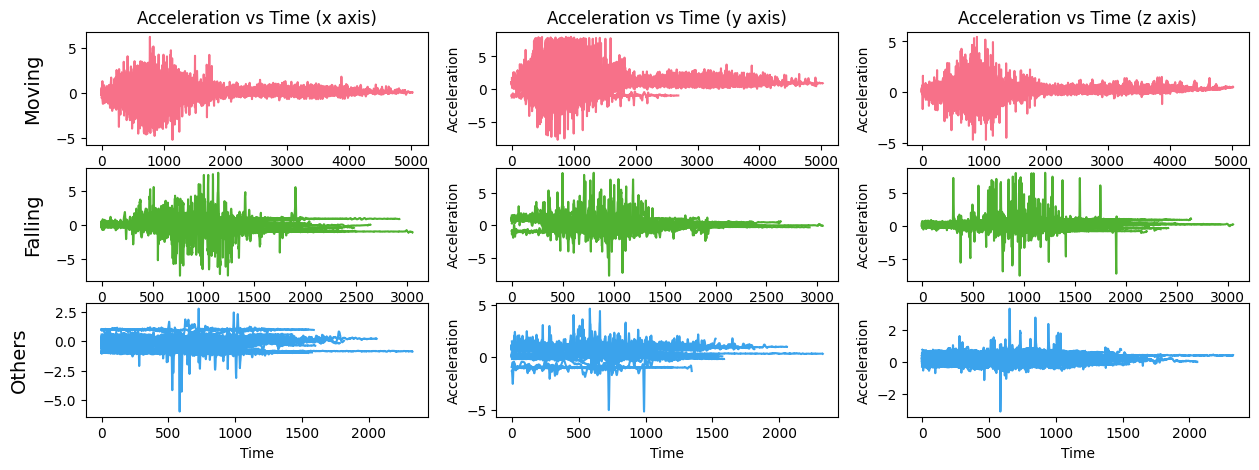

In [8]:
# Define a color palette
palette = sns.color_palette('husl', n_colors=3)

# Create a color dictionary
color_dict = dict(zip([1, 2, 3], palette))
# Create a figure with three subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 5))

# Plot the data in each subplot
for i, df in enumerate(df_list):
    for j, col in enumerate(df.columns[:-1]):
        activity_type = labels[i]
        axs[activity_type-1][j].plot(df[col], color=color_dict[labels[i]])
        axs[activity_type-1][j].set_xlabel('Time')
        axs[activity_type-1][j].set_ylabel('Acceleration')
    
        axs[0][j].set_title(f'Acceleration vs Time ({["x", "y", "z"][j]} axis)')

    axs[activity_type-1][0].set_ylabel(f'{["Moving", "Falling", "Others"][activity_type-1]}', fontsize=14, rotation=90, labelpad=10)
    axs[activity_type-1][1].set_ylabel('Acceleration')
    axs[activity_type-1][2].set_ylabel('Acceleration')

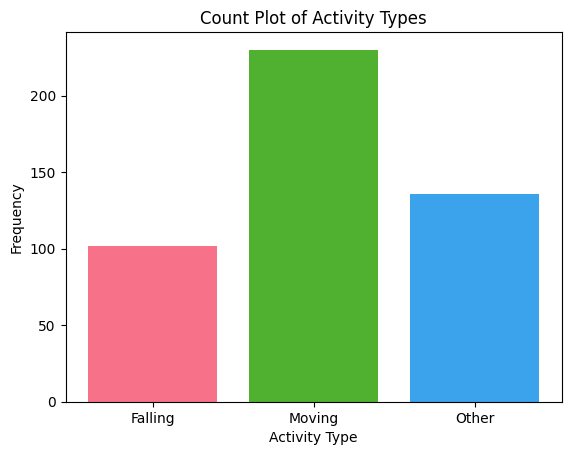

In [9]:
# Class distribution
# Calculate the unique values and their frequencies
text_labels = labels.replace([1,2,3],['Moving','Falling','Other'])
unique_values, frequencies = np.unique(text_labels, return_counts=True)

# Plotting the count plot
plt.bar(unique_values, frequencies, color = color_dict.values())
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.title('Count Plot of Activity Types')
plt.show()

# 3. Feature Extraction and Visualization

It's time to extract the numerical feature from our dataset to analyze it. In order to do this, we brainstormed as many relevant feature as possible to calculate that could be relevant for our problem. We identified three macro areas:

1. Basic Statistical Measures (min, max, std, ...)
2. Time Series Analysis inspired measures (turning points, zero cross count, autocorrelation, ...)
3. Signal Processing inspired measures (AUC, Peak to Peak distance, ...)

Below is the complete list, consisting of 24 features, each one extracted from each of the time series of the observation (x,y,z axis), for a total of 72 features.

The features functions and how they are calcolated are into the ``/features.py`` file. The function below calculates the feature for every observation of the df_list and append a row with the features to tsfeat.

| Statistical Measures                    | Time Series Analysis                                                                                                                                                                                                                              | Signal Processing                                       |
|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------|
| Max, Min, Mean,  Median, Std,  Variance, Interquartile Range | Autocorrelation, Kurtosis,  Mean Absolute Deviation, Mean (Absolute) Difference,  Median Absolute Deviation, Median (Absolute) Difference,  Negative (Pos) Turning Points, Slope,  Sum Absolute Difference, Zero Cross Count | Area Under Curve,  Peak to Peak distance,  Total Energy |

In [10]:
# Import the Features class and the inspect module
from features import Features
import inspect

# Define a function to calculate features for each signal in a dataframe
def calc_features(df):
   
    f = Features()
    
    # Get a list of all the methods of the Features object
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)
    
    # Create an empty dataframe to store the features
    df_features = pd.DataFrame()

    # Loop through each signal in the dataframe
    for signals in df:
        # Create empty lists to store the feature names and values
        names = []
        values = []
        
        # Loop through each column in the signal [x, y, z]
        for columns in signals.columns[:-1]: 
            # Get the signal data as a numpy array
            signal = np.array(signals[columns])
            
            # Create a Features object
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)
            
            # Loop through each method and calculate the feature value
            for method in methods:
                # Append the feature name and value to the lists
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))
        
        # Create a new dataframe with the feature values and names as columns
        df_new = pd.DataFrame(values, index=names).T
        
        # Concatenate the new dataframe with the existing dataframe
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features,df_new])
                
    # Return the dataframe of features
    return df_features

In [11]:
tsfeat = calc_features(df_list)
tsfeat.head()

,auc_x,autocorr_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,distance_x,interq_range_x,...,median_abs_deviation_z,median_abs_diff_z,median_diff_z,negative_turning_z,pk_pk_distance_z,positive_turning_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,1.557371,89.024744,0.693289,0.066696,0.061151,-0.784883,0.186931,0.034943,2260.563161,0.154148,...,0.072863,0.008507,-0.000759,428.0,0.592104,429.0,-0.000002,32.922238,1.857917,98.0
0,2.171963,197.427118,0.470244,-0.163410,-0.127067,-1.603301,0.266975,0.071276,2016.743751,0.225793,...,0.081479,0.012172,0.001242,293.0,1.692158,292.0,-0.000028,52.561213,6.522787,96.0
0,3.710821,639.263726,0.177058,-0.478372,-0.434809,-1.057066,0.436291,0.190350,1524.121979,0.927964,...,0.061639,0.007102,0.000148,306.0,0.624218,306.0,0.000082,16.393202,19.311767,0.0
0,4.674279,970.543685,0.281936,-0.454445,-0.090394,-4.354404,0.545581,0.297658,1927.563380,0.998039,...,0.177410,0.006833,-0.000236,424.0,3.948470,423.0,-0.000239,28.823818,21.526363,10.0
0,1.229189,89.273891,1.308709,0.255591,0.248850,-0.325685,0.177186,0.031395,923.036793,0.099313,...,0.055582,0.008076,0.000255,168.0,1.313669,168.0,-0.000026,14.809155,7.223184,20.0


In [12]:
tsfeat.columns[0:24]

Index(['auc_x', 'autocorr_x', 'calc_max_x', 'calc_mean_x', 'calc_median_x',
       'calc_min_x', 'calc_std_x', 'calc_var_x', 'distance_x',
       'interq_range_x', 'kurtosis_x', 'mean_abs_deviation_x',
       'mean_abs_diff_x', 'mean_diff_x', 'median_abs_deviation_x',
       'median_abs_diff_x', 'median_diff_x', 'negative_turning_x',
       'pk_pk_distance_x', 'positive_turning_x', 'slope_x', 'sum_abs_diff_x',
       'total_energy_x', 'zero_cross_x'],
      dtype='object')

In [13]:
# Add the class labels as a new column to the tsfeat dataset
#tsfeat['class_label']=list(labels)
# Create a pairplot of the dataset
#sns.pairplot(tsfeat, hue='class_label')

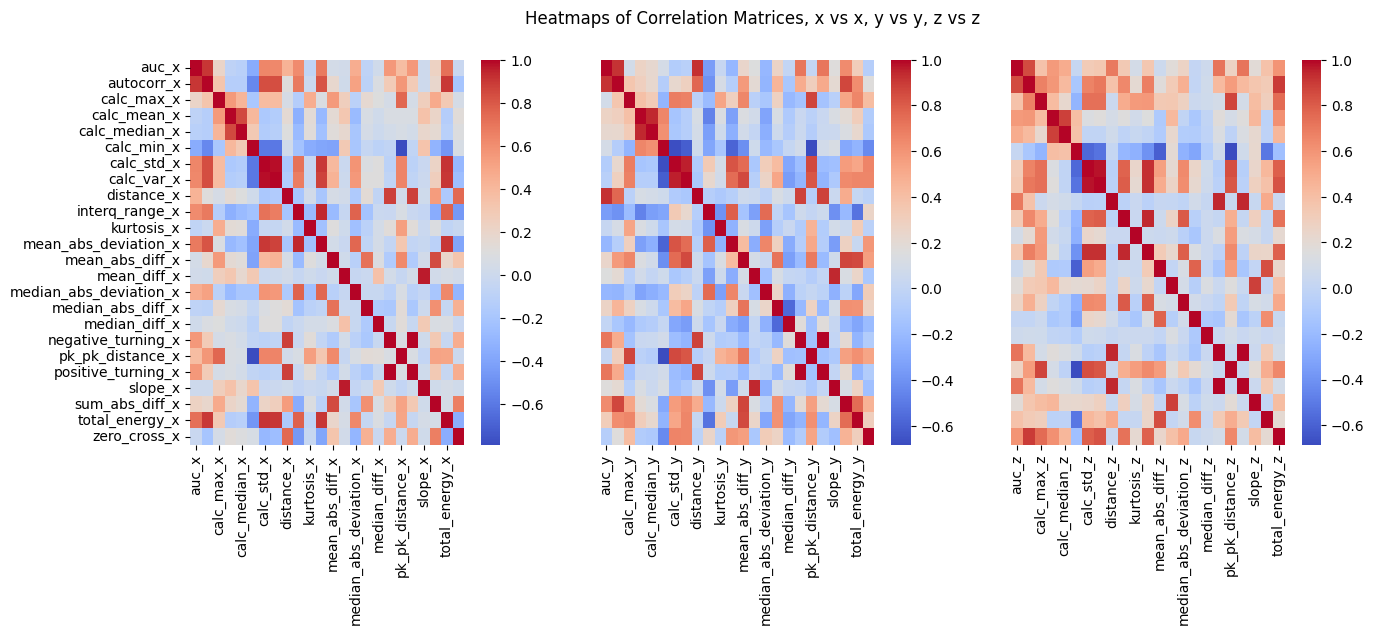

In [14]:
# Calculate the correlation matrices
corr_matrix1 = tsfeat.iloc[:, :24].corr()
corr_matrix2 = tsfeat.iloc[:, 24:48].corr()
corr_matrix3 = tsfeat.iloc[:, 48:-1].corr()

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a heatmap in each subplot
sns.heatmap(corr_matrix1, cmap='coolwarm',  ax=axes[0])
sns.heatmap(corr_matrix2, cmap='coolwarm',  ax=axes[1], yticklabels=False)
sns.heatmap(corr_matrix3, cmap='coolwarm',  ax=axes[2], yticklabels=False)

# Set the title of the plot
fig.suptitle('Heatmaps of Correlation Matrices, x vs x, y vs y, z vs z')

# Show the plot
plt.show()

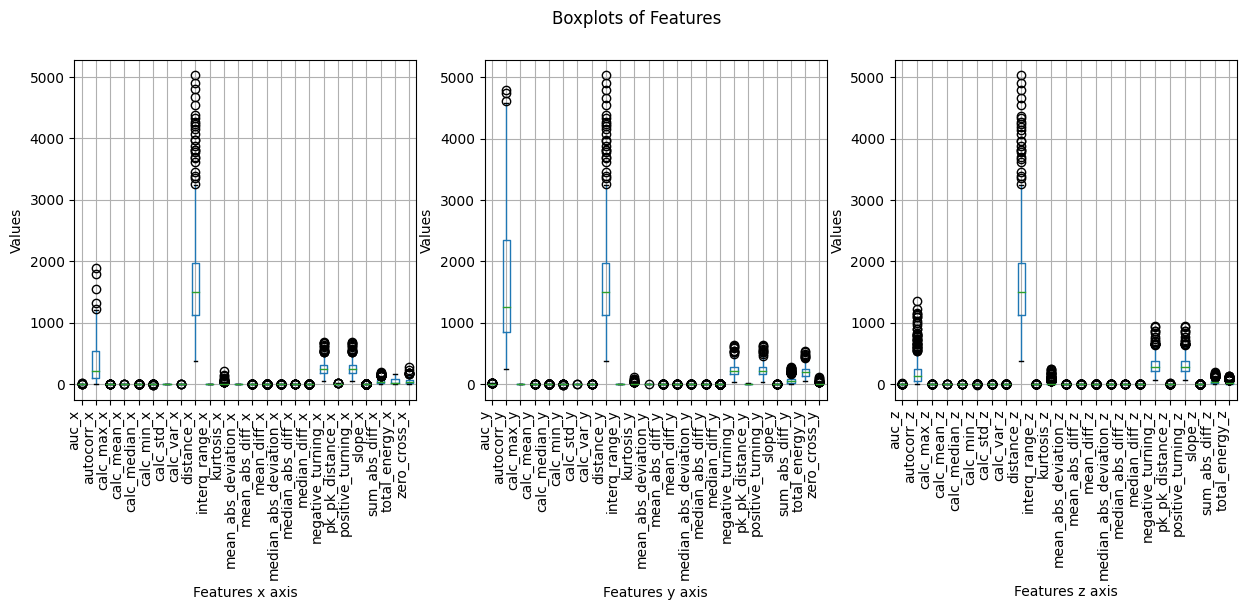

In [15]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a boxplot in each subplot
tsfeat.iloc[:, :24].boxplot(ax=axes[0])
tsfeat.iloc[:, 24:48].boxplot(ax=axes[1])
tsfeat.iloc[:, 48:-1].boxplot(ax=axes[2])

# Set the labels and title of the plot
fig.suptitle('Boxplots of Features')
axes[0].set_xlabel('Features x axis')
axes[0].set_ylabel('Values')
axes[1].set_xlabel('Features y axis')
axes[1].set_ylabel('Values')
axes[2].set_xlabel('Features z axis')
axes[2].set_ylabel('Values')
fig.autofmt_xdate(rotation=90)

# Show the plot
plt.show()

## Interactive visualization of boxplots feature vs classes, divided by axis

In [16]:
from ipywidgets import interact, IntSlider, Layout

# Define a function to create a boxplot for a given feature
def create_boxplot(feature):
    # Group the data by class label
    grouped_data = tsfeat.copy()
    grouped_data['activity'] = list(labels.replace([1,2,3],['Moving','Falling','Others']))

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Create a boxplot in each subplot
    grouped_data.iloc[:, :].boxplot(ax=axes[0], column = tsfeat.columns[feature], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[1], column = tsfeat.columns[feature+24], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[2], column = tsfeat.columns[feature+48], by='activity')

    # Set the labels and title of the plot
    fig.suptitle('Boxplots of Features {}'.format(tsfeat.columns[feature][:-2]))

# Create a slider to change features
slider_layout = Layout(width='50%')
feature_slider = IntSlider(min=0, max=tsfeat.shape[1]/3 -1, step=1, value=0, layout=slider_layout, description='Select Feature:', style={'description_width': 'initial', 'handle_color': 'blue'})


# Create an interactive plot
interact(create_boxplot, feature=feature_slider)

interactive(children=(IntSlider(value=0, description='Select Feature:', layout=Layout(width='50%'), max=23, st…

<function __main__.create_boxplot(feature)>

# 4. Model making

## Feature Selection

In [17]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SequentialFeatureSelector, RFE, SelectFromModel, VarianceThreshold
#from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import Ridge, LogisticRegression

from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


In [19]:
# Compute the correlation matrix
corr_matrix = tsfeat.corr()

# Select the highly correlated features
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.6:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            if colname_i not in highly_correlated_features and colname_j not in highly_correlated_features:
                highly_correlated_features.add(colname_i)

# Remove the highly correlated features from the dataset
tsfeat_no_corr = tsfeat.drop(highly_correlated_features, axis=1)

# Print the remaining features
print('Remaining Features:', tsfeat_no_corr.columns)

Remaining Features: Index(['auc_x', 'calc_max_x', 'calc_mean_x', 'calc_min_x', 'distance_x',
       'kurtosis_x', 'mean_abs_diff_x', 'mean_diff_x',
       'median_abs_deviation_x', 'median_diff_x', 'calc_mean_y',
       'interq_range_y', 'kurtosis_y', 'mean_diff_y', 'median_diff_y',
       'zero_cross_y', 'autocorr_z', 'calc_mean_z', 'calc_min_z', 'kurtosis_z',
       'mean_diff_z', 'median_abs_deviation_z', 'median_diff_z',
       'zero_cross_z'],
      dtype='object')


In [32]:
# Division in Train and Test set (66%-33%)
X_train, X_test, Y_train, Y_test = train_test_split(tsfeat_no_corr, np.array(list(labels)), test_size=0.33, random_state=1999, stratify=np.array(list(labels)))

In [33]:
X_train.head()

,auc_x,calc_max_x,calc_mean_x,calc_min_x,distance_x,kurtosis_x,mean_abs_diff_x,mean_diff_x,median_abs_deviation_x,median_diff_x,...,median_diff_y,zero_cross_y,autocorr_z,calc_mean_z,calc_min_z,kurtosis_z,mean_diff_z,median_abs_deviation_z,median_diff_z,zero_cross_z
0,2.549912,0.298440,-0.326550,-1.101168,1413.119678,-1.459052,0.008684,0.000899,0.109223,0.000061,...,0.000000,2.0,31.162640,-0.003208,-0.255072,0.721623,0.000157,0.080948,-0.000030,55.0
0,0.671669,0.364084,-0.097115,-1.461741,661.875167,1.281543,0.020796,-0.001125,0.108430,0.000160,...,0.000000,2.0,13.414309,0.061151,-1.152842,37.327539,-0.000071,0.039250,0.000642,17.0
0,1.557371,0.693289,0.066696,-0.784883,2260.563161,3.513048,0.022133,-0.000023,0.075489,-0.000921,...,0.000163,0.0,20.985176,0.010559,-0.243396,-0.450298,-0.000002,0.072863,-0.000759,98.0
0,3.698214,0.263688,-0.495775,-1.032323,1484.285749,-1.801878,0.010164,0.000451,0.227569,0.000063,...,0.000000,8.0,141.282039,0.289734,-0.386913,5.065840,-0.000116,0.047947,-0.000020,2.0
0,3.667780,0.841322,-0.476050,-4.436784,1493.707443,12.098491,0.025762,-0.000565,0.215265,-0.000237,...,-0.000124,19.0,384.970512,-0.205380,-5.901066,64.620110,-0.000452,0.268182,0.000233,27.0


In [34]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


(313, 24)
(155, 24)
(313,)
(155,)


## 4.1 Logistic Regression

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Train the logistic regression classifier with the best hyperparameters
classifier = grid_search.best_estimator_
classifier.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = classifier.predict(X_test_scaled)

# Get the classification report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names=['Moving', 'Falling', 'Others']))
print('Accuracy: ' + str(accuracy) + '%')


# Calculate the odds ratio and effect size
odds_ratio = np.exp(classifier.coef_)
effect_size = odds_ratio / (odds_ratio + 1)

print('Odds Ratio:', odds_ratio)
print('Effect Size:', effect_size)

              precision    recall  f1-score   support

      Moving       0.97      0.97      0.97        76
     Falling       0.97      0.91      0.94        34
      Others       0.91      0.96      0.93        45

    accuracy                           0.95       155
   macro avg       0.95      0.95      0.95       155
weighted avg       0.96      0.95      0.95       155

Accuracy: 95.48387096774194%
Odds Ratio: [[0.67683258 1.08243239 1.15234654 1.01516259 1.76710129 1.23421371
  2.10962601 1.01195108 0.62558816 0.96175647 1.16681717 0.56339202
  1.15732296 1.3780108  0.88233086 1.16329814 0.97150966 1.0883934
  0.90478256 0.95700936 0.87954048 0.70303446 1.05277758 1.45591025]
 [1.37321043 1.46097072 1.02427718 0.65715772 1.01288386 1.24469809
  0.87332731 0.98438697 1.32285424 1.09111978 0.78167987 1.69031598
  0.97687953 0.71910236 1.07863541 1.27636112 1.2738189  0.81884026
  0.78631451 1.31485935 1.1033136  1.35742156 1.16608045 0.9372207 ]
 [1.07592413 0.63235027 0.8472262

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [58]:
# Get the classification report and accuracy
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names=['Moving', 'Falling', 'Others']))
print('Accuracy: ' + str(accuracy) + '%')

# Calculate the probabilities for each class
y_prob = classifier.predict_proba(X_test_scaled)

# Calculate the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_prob[:, i], pos_label=classifier.classes_[i])
    roc_auc[i] = roc_auc_score(Y_test, y_prob[:, i], multi_class='ovr')

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green']
for i, color in zip(range(len(classifier.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(classifier.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

      Moving       0.97      0.97      0.97        76
     Falling       0.97      0.91      0.94        34
      Others       0.91      0.96      0.93        45

    accuracy                           0.95       155
   macro avg       0.95      0.95      0.95       155
weighted avg       0.96      0.95      0.95       155

Accuracy: 95.48387096774194%


AxisError: axis 1 is out of bounds for array of dimension 1

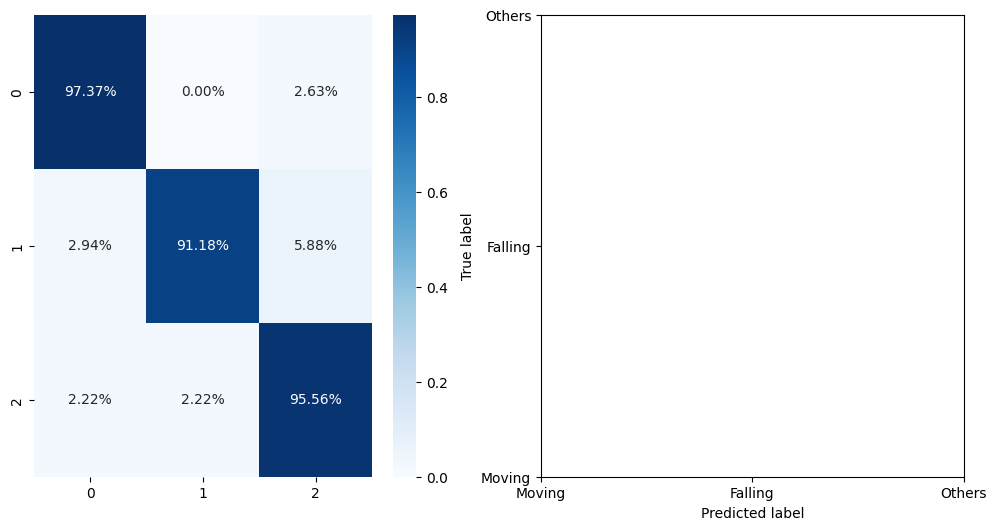

In [56]:
# Plot the feature importances and confusion matrix side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the confusion matrix
cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[0])   
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1, 2], ['Moving', 'Falling', 'Others'])
plt.yticks([0, 1, 2], ['Moving', 'Falling', 'Others'])
plt.show()


## 4.2 Random Forest

In [35]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train the random forest classifier using cross-validation and hyperparameter tuning
classifier = RandomForestClassifier()
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the random forest classifier using the best hyperparameters
classifier = RandomForestClassifier(**best_params)
classifier.fit(X_train, Y_train)

# Get the feature importances
importances = classifier.feature_importances_

# Predict test data
y_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names=['Moving', 'Falling', 'Others']))
print('Accuracy: ' + str(accuracy) + '%')

# Evaluate the model using cross-validation
scores = cross_val_score(classifier, tsfeat, labels, cv=5)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

              precision    recall  f1-score   support

      Moving       0.97      1.00      0.99        76
     Falling       0.86      0.94      0.90        34
      Others       0.97      0.87      0.92        45

    accuracy                           0.95       155
   macro avg       0.94      0.94      0.94       155
weighted avg       0.95      0.95      0.95       155

Accuracy: 94.83870967741936%
Cross-validation scores: [0.96808511 0.95744681 0.9787234  0.98924731 0.97849462]
Mean cross-validation score: 0.9743994509265616


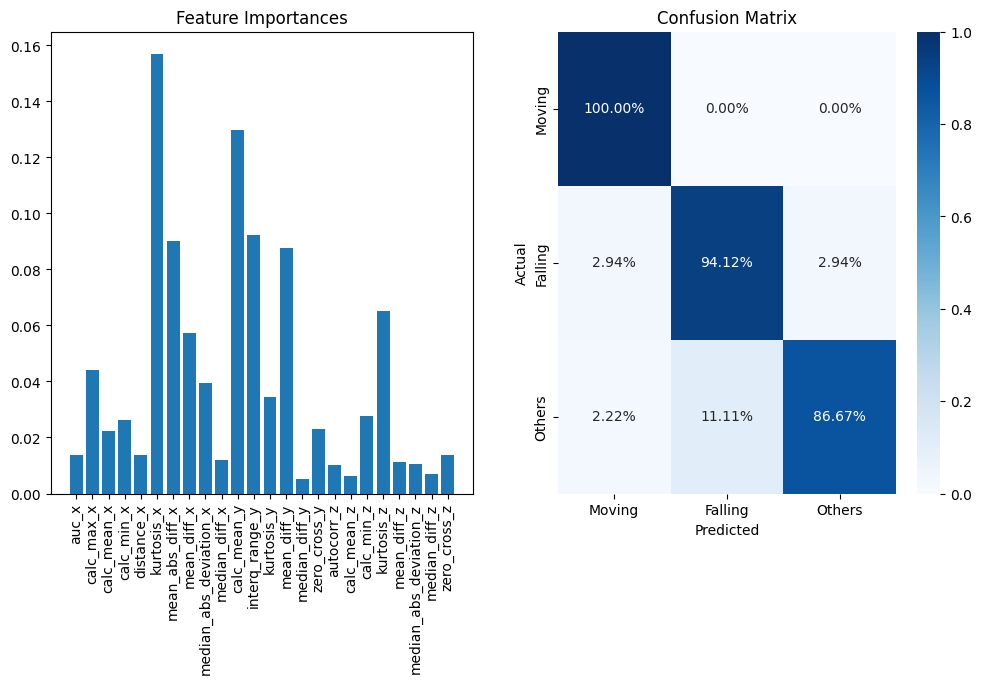

In [36]:
# Plot the feature importances and confusion matrix side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the feature importances
axs[0].bar(X_train.columns, importances)
values_list = np.arange(0, len(X_train.columns))
axs[0].xaxis.set_ticks(values_list)
axs[0].set_xticklabels(X_train.columns, rotation=90)
axs[0].set_title('Feature Importances')

# Plot the confusion matrix
cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Confusion Matrix')
axs[1].set_xticklabels(['Moving', 'Falling', 'Others'])
axs[1].set_yticklabels(['Moving', 'Falling', 'Others'])

plt.show()

In [37]:
# Select the top k features
k = 2
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the random forest classifier using the top k features
classifier = RandomForestClassifier(**best_params)
classifier.fit(X_train[top_k_features], Y_train)

# Predict test data
y_predict = classifier.predict(X_test[top_k_features])

# Get the classification report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names=['Moving', 'Falling', 'Others']))
print('Accuracy: ' + str(accuracy) + '%')

# Evaluate the model using cross-validation
scores = cross_val_score(classifier, tsfeat[top_k_features], labels, cv=5)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

              precision    recall  f1-score   support

      Moving       0.97      0.99      0.98        76
     Falling       0.88      0.88      0.88        34
      Others       0.91      0.89      0.90        45

    accuracy                           0.94       155
   macro avg       0.92      0.92      0.92       155
weighted avg       0.94      0.94      0.94       155

Accuracy: 93.54838709677419%
Cross-validation scores: [0.90425532 0.91489362 0.95744681 0.89247312 0.93548387]
Mean cross-validation score: 0.9209105467856326


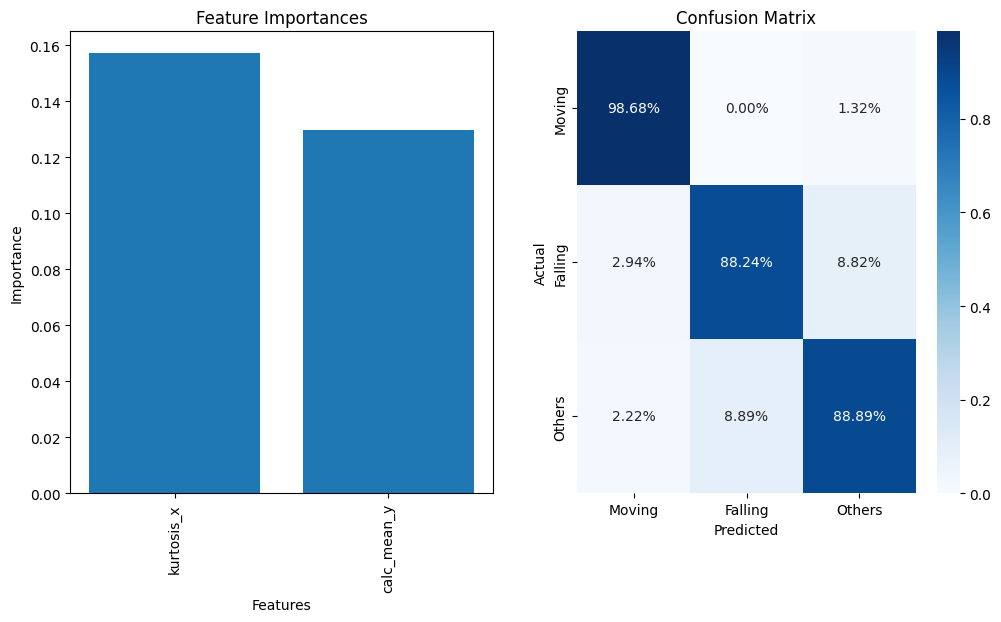

In [38]:
# Plot the feature importances and confusion matrix side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the feature importances
axs[0].bar(top_k_features, importances[top_k_indices])
values_list = np.arange(0, k)
axs[0].xaxis.set_ticks(values_list)
axs[0].set_xticklabels(top_k_features, rotation=90)
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Importance')
axs[0].set_title('Feature Importances')

# Plot the confusion matrix
cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Confusion Matrix')
axs[1].set_xticklabels(['Moving', 'Falling', 'Others'])
axs[1].set_yticklabels(['Moving', 'Falling', 'Others'])

plt.show()

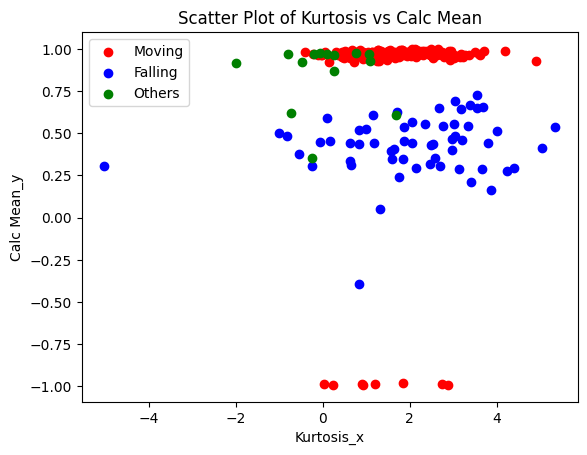

In [41]:
# Define the x and y variables
x = np.log(X_train['kurtosis_x'])
y = X_train['calc_mean_y']

# Define the colors for each label
named_labels = pd.Series(Y_train).replace({1: 'Moving', 2: 'Falling', 3: 'Others'})
colors = {'Moving': 'red', 'Falling': 'blue', 'Others': 'green'}

# Create the scatter plot
fig, ax = plt.subplots()
for label in colors:
    mask = named_labels == label
    ax.scatter(x[list(mask)], y[list(mask)], c=colors[label], label=label)

# Set the axis labels and title
ax.set_xlabel('Kurtosis_x')
ax.set_ylabel('Calc Mean_y')
ax.set_title('Scatter Plot of Kurtosis vs Calc Mean')

# Add the legend
ax.legend()

# Show the plot
plt.show()

In [45]:
# Assuming y is a numpy array
unique_values, counts = np.unique(Y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print('Value:', value, 'Count:', count)

Value: 1 Count: 154
Value: 2 Count: 68
Value: 3 Count: 91


## Pause

In [32]:
# Classification with Random Forests
classifier = RandomForestClassifier(min_samples_split=10)

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
model = classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       0.99      0.99      0.99        79
     falling       0.90      0.97      0.93        29
      others       0.98      0.94      0.96        47

    accuracy                           0.97       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.97      0.97      0.97       155

Accuracy: 96.7741935483871%


In [12]:
# Classification with KNN

classifier = KNeighborsClassifier()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       0.99      0.97      0.98        79
     falling       0.93      0.93      0.93        29
      others       0.92      0.94      0.93        47

    accuracy                           0.95       155
   macro avg       0.94      0.95      0.95       155
weighted avg       0.96      0.95      0.96       155

Accuracy: 95.48387096774194%


In [17]:
# Classification with Naive Bayes
from sklearn.naive_bayes import GaussianNB 
classifier = GaussianNB()

activities = ['moving', 'falling', 'others']
#activities = ['moving', 'running', 'jumping','waling_down', 'walking_up', 'falling','lying','other']


# Train The Classifier
classifier.fit(X_train.iloc[:,:], Y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test.iloc[:,:])

# Get the Classification Report
accuracy = accuracy_score(Y_test, y_predict)*100
print(classification_report(Y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')


              precision    recall  f1-score   support

      moving       1.00      0.99      0.99        79
     falling       0.85      1.00      0.92        29
      others       0.98      0.89      0.93        47

    accuracy                           0.96       155
   macro avg       0.94      0.96      0.95       155
weighted avg       0.97      0.96      0.96       155

Accuracy: 96.12903225806451%


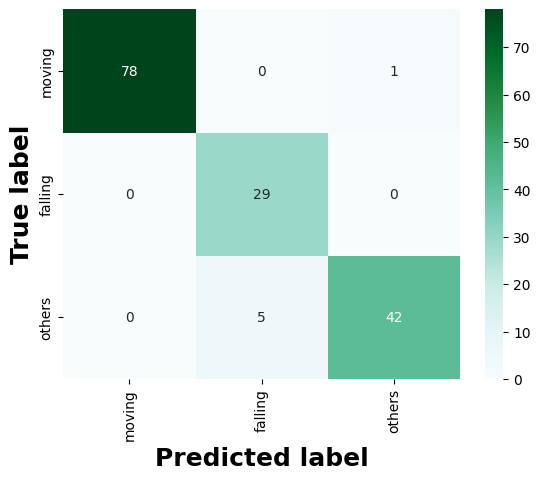

In [19]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()